In [ ]:
# Pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# PySpark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, countDistinct, to_date, to_timestamp, when, expr, date_trunc, count, avg
from pyspark.sql.functions import explode, split, trim
from pyspark.sql import functions as F
from pyspark.sql.types import ArrayType, StringType
from pyspark.sql.functions import count as Fcount

spark = (SparkSession.builder
         .appName("BNPL_external_data")
         .master("local[*]")
         .config("spark.driver.bindAddress","127.0.0.1")
         .config("spark.driver.host","127.0.0.1")
         .config("spark.ui.enabled","true")     # 如不看UI可设 false
         .config("spark.ui.port","0")           # 0=随机端口，避免 4040 冲突
         .config("spark.blockManager.port","0") # 随机
         .config("spark.driver.memory","6g")
         .getOrCreate())

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/09/06 23:29:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [ ]:
population_path = "external_data/population_by_sexgender.csv"

population = pd.read_csv(population_path)

In [3]:
population.head(10)

,STRUCTURE,STRUCTURE_ID,STRUCTURE_NAME,ACTION,MEASURE,Measure,SEX,Sex,AGE,Age,...,TIME_PERIOD,Time Period,OBS_VALUE,Observation Value,UNIT_MEASURE,Unit of Measure,OBS_STATUS,Observation Status,OBS_COMMENT,Observation Comment
0,DATAFLOW,ABS:ERP_ASGS2021(1.0.0),"ERP by SA2 (ASGS Edition 3), Age and Sex, 2001...",I,ERP,Estimated Resident Population,2,Females,A50,50-54,...,2024,NaN,45954,NaN,PSNS,Persons,NaN,NaN,NaN,NaN
1,DATAFLOW,ABS:ERP_ASGS2021(1.0.0),"ERP by SA2 (ASGS Edition 3), Age and Sex, 2001...",I,ERP,Estimated Resident Population,3,Persons,A35,35-39,...,2024,NaN,38372,NaN,PSNS,Persons,NaN,NaN,NaN,NaN
2,DATAFLOW,ABS:ERP_ASGS2021(1.0.0),"ERP by SA2 (ASGS Edition 3), Age and Sex, 2001...",I,ERP,Estimated Resident Population,3,Persons,A25,25-29,...,2024,NaN,34578,NaN,PSNS,Persons,NaN,NaN,NaN,NaN
3,DATAFLOW,ABS:ERP_ASGS2021(1.0.0),"ERP by SA2 (ASGS Edition 3), Age and Sex, 2001...",I,ERP,Estimated Resident Population,3,Persons,A15,15-19,...,2024,NaN,179875,NaN,PSNS,Persons,NaN,NaN,NaN,NaN
4,DATAFLOW,ABS:ERP_ASGS2021(1.0.0),"ERP by SA2 (ASGS Edition 3), Age and Sex, 2001...",I,ERP,Estimated Resident Population,2,Females,A60,60-64,...,2024,NaN,146743,NaN,PSNS,Persons,NaN,NaN,NaN,NaN
5,DATAFLOW,ABS:ERP_ASGS2021(1.0.0),"ERP by SA2 (ASGS Edition 3), Age and Sex, 2001...",I,ERP,Estimated Resident Population,1,Males,A60,60-64,...,2024,NaN,19523,NaN,PSNS,Persons,NaN,NaN,NaN,NaN
6,DATAFLOW,ABS:ERP_ASGS2021(1.0.0),"ERP by SA2 (ASGS Edition 3), Age and Sex, 2001...",I,ERP,Estimated Resident Population,2,Females,A40,40-44,...,2024,NaN,3615,NaN,PSNS,Persons,NaN,NaN,NaN,NaN
7,DATAFLOW,ABS:ERP_ASGS2021(1.0.0),"ERP by SA2 (ASGS Edition 3), Age and Sex, 2001...",I,ERP,Estimated Resident Population,3,Persons,A75,75-79,...,2024,NaN,57201,NaN,PSNS,Persons,NaN,NaN,NaN,NaN
8,DATAFLOW,ABS:ERP_ASGS2021(1.0.0),"ERP by SA2 (ASGS Edition 3), Age and Sex, 2001...",I,ERP,Estimated Resident Population,3,Persons,TOT,All ages,...,2024,NaN,2384371,NaN,PSNS,Persons,NaN,NaN,NaN,NaN
9,DATAFLOW,ABS:ERP_ASGS2021(1.0.0),"ERP by SA2 (ASGS Edition 3), Age and Sex, 2001...",I,ERP,Estimated Resident Population,1,Males,A80,80-84,...,2024,NaN,900,NaN,PSNS,Persons,NaN,NaN,NaN,NaN


In [4]:
population.columns

Index(['STRUCTURE', 'STRUCTURE_ID', 'STRUCTURE_NAME', 'ACTION', 'MEASURE',
       'Measure', 'SEX', 'Sex', 'AGE', 'Age', 'REGION_TYPE', 'Geography Level',
       'ASGS_2021', 'Region', 'FREQ', 'Frequency', 'TIME_PERIOD',
       'Time Period', 'OBS_VALUE', 'Observation Value', 'UNIT_MEASURE',
       'Unit of Measure', 'OBS_STATUS', 'Observation Status', 'OBS_COMMENT',
       'Observation Comment'],
      dtype='object')

In [5]:
# 仅保留必要列（注意只保留 Age，不保留 AGE）
needed_cols = ["ASGS_2021", "Region", "Age", "Sex", "TIME_PERIOD", "OBS_VALUE"]
missing = [c for c in needed_cols if c not in population.columns]
if missing:
    raise ValueError(f"缺失必要列: {missing}")

pop = population[needed_cols].copy()

In [6]:
# 3) 选择最新年份（更稳健；如需固定为 2024，改为 pop = pop[pop["TIME_PERIOD"] == 2024]）
# 先把 TIME_PERIOD 转为数值（有些版本是字符串）
pop["TIME_PERIOD"] = pd.to_numeric(pop["TIME_PERIOD"], errors="coerce")
latest_year = int(pop["TIME_PERIOD"].max())
pop = pop[pop["TIME_PERIOD"] == latest_year].copy()

In [7]:
# 4) 人口数转数值并清理缺失
pop["OBS_VALUE"] = pd.to_numeric(pop["OBS_VALUE"], errors="coerce")
pop = pop.dropna(subset=["ASGS_2021", "Region", "Age", "OBS_VALUE"])

In [8]:
# 5) （可选）去重/排序，便于检查
pop = pop.drop_duplicates(subset=["ASGS_2021", "Age", "Sex", "TIME_PERIOD"])
pop = pop.sort_values(["ASGS_2021", "Age"]).reset_index(drop=True)

In [9]:
pop.head(10)

,ASGS_2021,Region,Age,Sex,TIME_PERIOD,OBS_VALUE
0,1GSYD,Greater Sydney,0-4,Persons,2024,309182
1,1GSYD,Greater Sydney,0-4,Males,2024,159041
2,1GSYD,Greater Sydney,0-4,Females,2024,150141
3,1GSYD,Greater Sydney,10-14,Males,2024,172609
4,1GSYD,Greater Sydney,10-14,Persons,2024,335629
5,1GSYD,Greater Sydney,10-14,Females,2024,163020
6,1GSYD,Greater Sydney,15-19,Females,2024,161624
7,1GSYD,Greater Sydney,15-19,Persons,2024,334274
8,1GSYD,Greater Sydney,15-19,Males,2024,172650
9,1GSYD,Greater Sydney,20-24,Males,2024,212991


In [10]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def age_start(a: str) -> int:
    """
    提取年龄段起始数值；'All ages' 返回 -1 以便放在最前/最后可控
    例: '0-4'->0, '15-19'->15, '85+'->85, '100+'->100, 'All ages'->-1
    """
    s = str(a).strip()
    if s.lower() == "all ages":
        return -1
    m = re.match(r"(\d+)", s)
    return int(m.group(1)) if m else 999

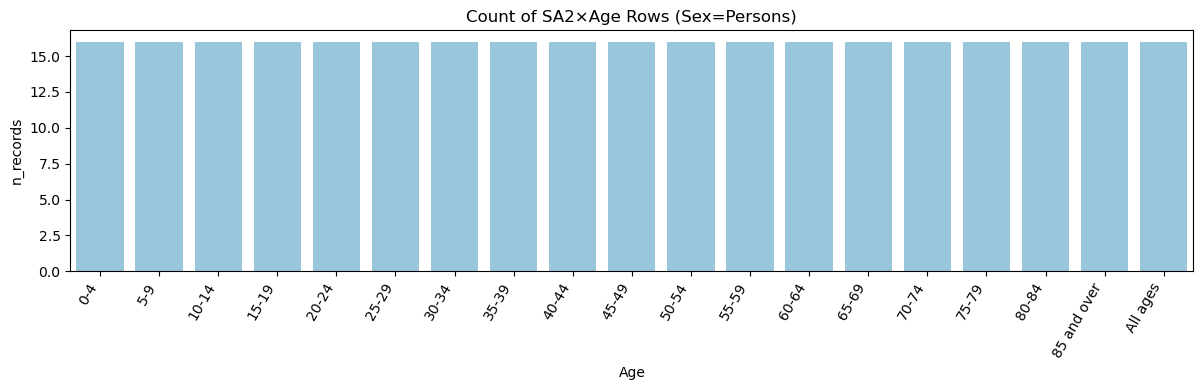

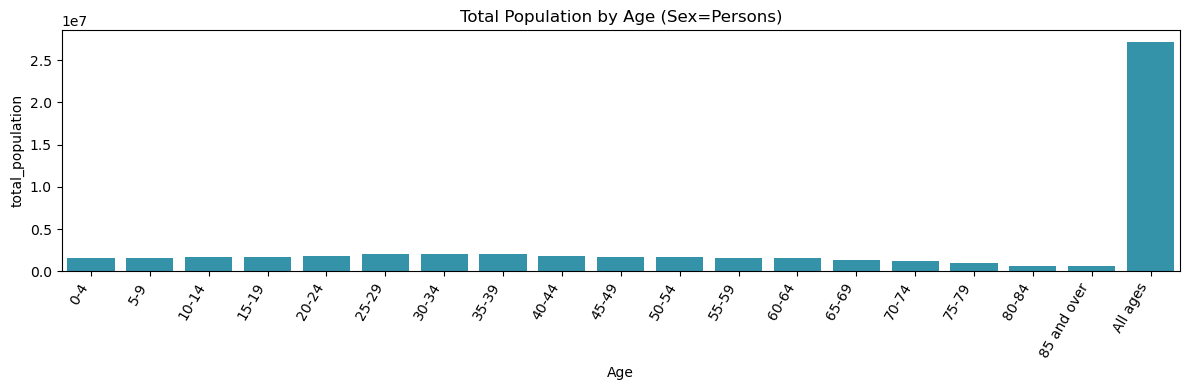

In [11]:
df = pop.copy()

# 只看总人口（Persons）；你也可以对 Males/Females 分别画
df_p = df[df["Sex"] == "Persons"].copy()

# 排序年龄段（把 All ages 放到最后展示）
age_order = sorted(df_p["Age"].unique(), key=lambda x: (age_start(x), x))
# 把 All ages 移到最后
age_order = [a for a in age_order if str(a).lower() != "all ages"] + \
            [a for a in age_order if str(a).lower() == "all ages"]

# 按年龄段的记录条数（有多少 SA2×Age 记录）
cnt = (df_p.groupby("Age", as_index=False)["ASGS_2021"]
          .count().rename(columns={"ASGS_2021":"n_records"}))
cnt["age_start"] = cnt["Age"].map(age_start)
cnt = cnt.sort_values(["age_start","Age"])

plt.figure(figsize=(12,4))
sns.barplot(data=cnt, x="Age", y="n_records", order=age_order, color="#8ecae6")
plt.xticks(rotation=60, ha='right')
plt.title("Count of SA2×Age Rows (Sex=Persons)")
plt.tight_layout()
plt.show()

# 各年龄段“总人口”（把所有 SA2 的人数相加）
tot = (df_p.groupby("Age", as_index=False)["OBS_VALUE"]
         .sum().rename(columns={"OBS_VALUE":"total_population"}))
tot["age_start"] = tot["Age"].map(age_start)
tot = tot.sort_values(["age_start","Age"])

plt.figure(figsize=(12,4))
sns.barplot(data=tot, x="Age", y="total_population", order=age_order, color="#219ebc")
plt.xticks(rotation=60, ha='right')
plt.title("Total Population by Age (Sex=Persons)")
plt.tight_layout()
plt.show()

In [12]:
mask_all = df_p["Age"].str.lower().eq("all ages")
totals = (df_p[mask_all].groupby("ASGS_2021", as_index=False)["OBS_VALUE"]
          .sum().rename(columns={"OBS_VALUE":"total_pop"}))
details = df_p[~mask_all].copy()

# 合并 All ages 作为分母（不删除，只看覆盖率）
merged = details.merge(totals, on="ASGS_2021", how="left")
coverage = merged["total_pop"].notna().mean()
print(f"SA2 拥有 'All ages' 作为总人口分母的覆盖率: {coverage:.1%}")

SA2 拥有 'All ages' 作为总人口分母的覆盖率: 100.0%


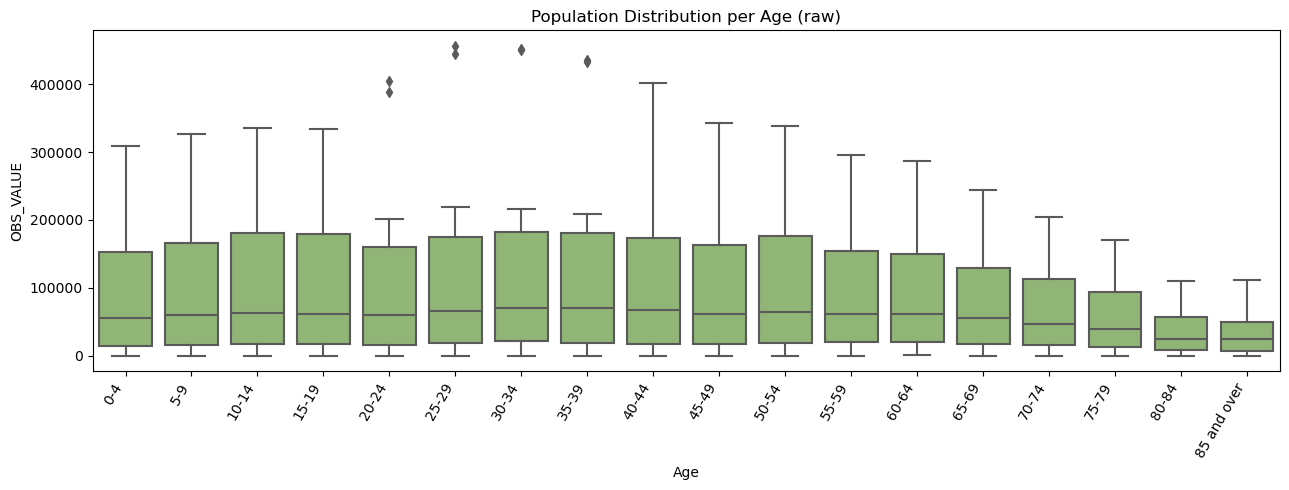

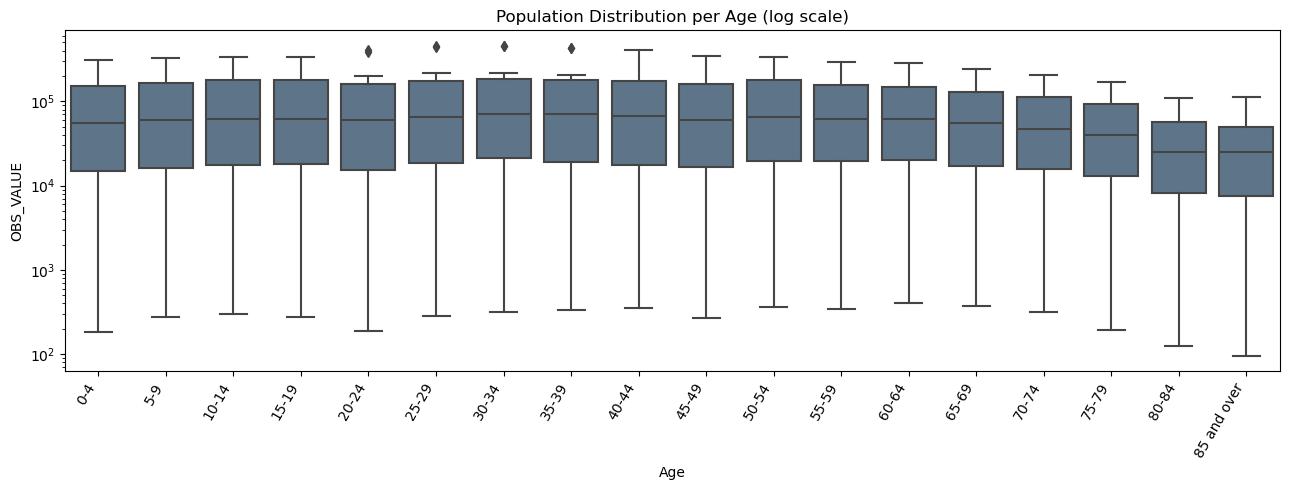

,Age,n,n_outliers,outlier_rate,q1,q3,lower,upper,age_start
0,0-4,16.0,0.0,0.000,14916.25,152351.75,-191237.000,358505.000,0
9,5-9,16.0,0.0,0.000,16314.50,165933.75,-208114.375,390362.625,5
1,10-14,16.0,0.0,0.000,17560.50,180494.75,-226840.875,424896.125,10
2,15-19,16.0,0.0,0.000,17947.75,180027.75,-225172.250,423147.750,15
3,20-24,16.0,2.0,0.125,15159.50,160789.25,-203285.125,379233.875,20
4,25-29,16.0,2.0,0.125,18582.00,175452.00,-216723.000,410757.000,25
5,30-34,16.0,2.0,0.125,21131.50,182461.00,-220862.750,424455.250,30
6,35-39,16.0,2.0,0.125,18979.00,181372.50,-224611.250,424962.750,35
7,40-44,16.0,0.0,0.000,17603.75,173658.00,-216477.625,407739.375,40
8,45-49,16.0,0.0,0.000,16867.50,162684.00,-201857.250,381408.750,45


In [13]:
# 箱线图（原值；若跨度大可以使用对数）
plt.figure(figsize=(13,5))
sns.boxplot(data=df_p[~df_p["Age"].str.lower().eq("all ages")],
            x="Age", y="OBS_VALUE", order=age_order[:-1], color="#90be6d")
plt.xticks(rotation=60, ha='right')
plt.title("Population Distribution per Age (raw)")
plt.tight_layout()
plt.show()

# 对数坐标更易观察长尾
plt.figure(figsize=(13,5))
sns.boxplot(data=df_p[~df_p["Age"].str.lower().eq("all ages")],
            x="Age", y="OBS_VALUE", order=age_order[:-1], color="#577590")
plt.yscale("log")
plt.xticks(rotation=60, ha='right')
plt.title("Population Distribution per Age (log scale)")
plt.tight_layout()
plt.show()

# IQR 异常点统计（每个年龄段单独算）
def iqr_outlier_flag(g: pd.DataFrame, k=1.5):
    q1 = g["OBS_VALUE"].quantile(0.25)
    q3 = g["OBS_VALUE"].quantile(0.75)
    iqr = q3 - q1
    lower, upper = q1 - k*iqr, q3 + k*iqr
    return pd.Series({
        "n": len(g),
        "n_outliers": ((g["OBS_VALUE"] < lower) | (g["OBS_VALUE"] > upper)).sum(),
        "outlier_rate": ((g["OBS_VALUE"] < lower) | (g["OBS_VALUE"] > upper)).mean(),
        "q1": q1, "q3": q3, "lower": lower, "upper": upper
    })

iqr_stats = (df_p[~df_p["Age"].str.lower().eq("all ages")]
             .groupby("Age").apply(iqr_outlier_flag).reset_index())
iqr_stats["age_start"] = iqr_stats["Age"].map(age_start)
iqr_stats = iqr_stats.sort_values(["age_start","Age"])
display(iqr_stats.head(10))

In [14]:
# 去除 Age == "All ages" 的行
pop = pop[pop["Age"] != "All ages"].copy()

# 检查是否删除成功
print("去除 All ages 后的行数:", len(pop))
print("仍然存在的 Age 类别:", pop["Age"].unique()[:20])  # 只看前20个

去除 All ages 后的行数: 864
仍然存在的 Age 类别: ['0-4' '10-14' '15-19' '20-24' '25-29' '30-34' '35-39' '40-44' '45-49'
 '5-9' '50-54' '55-59' '60-64' '65-69' '70-74' '75-79' '80-84'
 '85 and over']


In [15]:
# 只保留 Sex == Persons
pop = pop[pop["Sex"] == "Persons"].copy()

In [16]:
# 去除未成年人 (18岁以下)
exclude_ages = ["0-4", "5-9", "10-14", "15-19"]
pop = pop[~pop["Age"].isin(exclude_ages)]

In [17]:
# 定义年龄桶
def age_bucket(age_str):
    if age_str in ["20-24"]:
        return "18-24"
    elif age_str in ["25-29", "30-34"]:
        return "25-34"
    elif age_str in ["35-39", "40-44"]:
        return "35-44"
    elif age_str in ["45-49", "50-54"]:
        return "45-54"
    else:
        return "55+"
    
# 应用年龄桶
pop["Age_Bucket"] = pop["Age"].apply(age_bucket)

In [18]:
pop.head(20)

,ASGS_2021,Region,Age,Sex,TIME_PERIOD,OBS_VALUE,Age_Bucket
10,1GSYD,Greater Sydney,20-24,Persons,2024,404017,18-24
12,1GSYD,Greater Sydney,25-29,Persons,2024,456489,25-34
17,1GSYD,Greater Sydney,30-34,Persons,2024,451501,25-34
20,1GSYD,Greater Sydney,35-39,Persons,2024,432554,35-44
21,1GSYD,Greater Sydney,40-44,Persons,2024,402103,35-44
25,1GSYD,Greater Sydney,45-49,Persons,2024,343226,45-54
31,1GSYD,Greater Sydney,50-54,Persons,2024,338694,45-54
35,1GSYD,Greater Sydney,55-59,Persons,2024,295984,55+
37,1GSYD,Greater Sydney,60-64,Persons,2024,286363,55+
39,1GSYD,Greater Sydney,65-69,Persons,2024,243537,55+


In [19]:
# 删除原来的 Age 列，只保留 Age_Bucket
pop = pop.drop(columns=["Age"])

# 列名统一转小写
pop.columns = [c.lower() for c in pop.columns]

# age_bucket改名age替代
pop = pop.rename(columns={"age_bucket":"age"})

# 查看结果
pop.head(20)

,asgs_2021,region,sex,time_period,obs_value,age
10,1GSYD,Greater Sydney,Persons,2024,404017,18-24
12,1GSYD,Greater Sydney,Persons,2024,456489,25-34
17,1GSYD,Greater Sydney,Persons,2024,451501,25-34
20,1GSYD,Greater Sydney,Persons,2024,432554,35-44
21,1GSYD,Greater Sydney,Persons,2024,402103,35-44
25,1GSYD,Greater Sydney,Persons,2024,343226,45-54
31,1GSYD,Greater Sydney,Persons,2024,338694,45-54
35,1GSYD,Greater Sydney,Persons,2024,295984,55+
37,1GSYD,Greater Sydney,Persons,2024,286363,55+
39,1GSYD,Greater Sydney,Persons,2024,243537,55+


25/09/07 06:35:55 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 430851 ms exceeds timeout 120000 ms
25/09/07 06:35:55 WARN SparkContext: Killing executors is not supported by current scheduler.
25/09/07 06:35:58 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:53)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:342)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:132)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$